In [1]:
!python3 --version

Python 3.11.12


In [2]:
import numpy as np
import pandas as pd
import timeit
import pickle

print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)

numpy version:  2.3.2
pandas version:  2.3.1


In [3]:
%%time

# File import in dataframe
filename = "LAEI-2019-Emissions-Summary-including-Forecast.xlsx"
sheetname = "Emissions by Grid ID"
df1 = pd.read_excel(filename, sheet_name = sheetname)
df1.head()

CPU times: user 1min 15s, sys: 580 ms, total: 1min 16s
Wall time: 1min 16s


,Year,Grid ID 2019,LAEI 1km2 ID,Easting,Northing,Borough,Zone,Main Source Category,Sector,Source,...,n2o,nh3,nmvoc,nox,pb,pcb,pm10,pm2.5,so2,Emissions Unit
0,2030,1,5910,510500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019183,0.019183,NaN,tonnes/annum
1,2030,2,5911,511500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015719,0.015719,NaN,tonnes/annum
2,2030,3,5912,512500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019878,0.019878,NaN,tonnes/annum
3,2030,4,5915,515500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020946,0.020946,NaN,tonnes/annum
4,2030,5,5916,516500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020105,0.020105,NaN,tonnes/annum


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Dataset creation by filtering on Year 2019, Main Source Category 'Transport' and Sector 'Road Transport'
dataset1 = df1.loc[ (df1['Year']==2019) & (df1['Main Source Category']=="Transport") & (df1['Sector']=="Road Transport")].copy(deep = True)

# Removing Electric car since they produce no CO2 or Nox
dataset1 = dataset1.drop(dataset1.loc[dataset1['Source'].str.contains('electric', case=False, regex=False)].index)

# Removing non relevant columns, only keeping features - co2, nox - and targets - pm2.5, optionnaly pm10
dataset1 = dataset1.filter(items=['Grid ID 2019', 'co2', 'nox', 'pm10', 'pm2.5'])
dataset1 = dataset1.set_index('Grid ID 2019')

#print(dataset1)
#print()

# Replacing 0 values by mean values
mean_co2 = dataset1['co2'].mean()
mean_nox = dataset1['nox'].mean()
mean_pm10 = dataset1['pm10'].mean()
mean_pm25 = dataset1['pm2.5'].mean()

dataset1.loc[(dataset1['co2']== 0), 'co2'] = mean_co2
dataset1.loc[(dataset1['nox']== 0), 'nox'] = mean_nox
dataset1.loc[(dataset1['pm10']== 0), 'pm10'] = mean_pm10
dataset1.loc[(dataset1['pm2.5']== 0), 'pm2.5'] = mean_pm25

print(dataset1)
print()
print(dataset1.describe())
print()


                      co2        nox      pm10     pm2.5
Grid ID 2019                                            
1               31.262027   0.135768  0.014352  0.008164
2             4190.712040  16.716902  0.888255  0.536764
3             1849.507166   7.173389  0.400552  0.238611
4               31.158879   0.156213  0.016544  0.010265
5               28.133333   0.158901  0.016852  0.011086
...                   ...        ...       ...       ...
3456           268.764076   0.225646  0.050658  0.022702
3457          1307.588067   0.933334  0.309936  0.137778
3458          1654.324756   1.342779  0.398525  0.177336
3459            96.064233   0.146172  0.030548  0.013716
3460           801.702422   0.815941  0.202529  0.090511

[40680 rows x 4 columns]

                co2           nox          pm10         pm2.5
count  4.068000e+04  4.068000e+04  4.068000e+04  4.068000e+04
mean   2.514171e+02  5.631462e-01  6.690753e-02  3.502392e-02
std    5.366679e+02  1.363688e+00  1.295888e-0

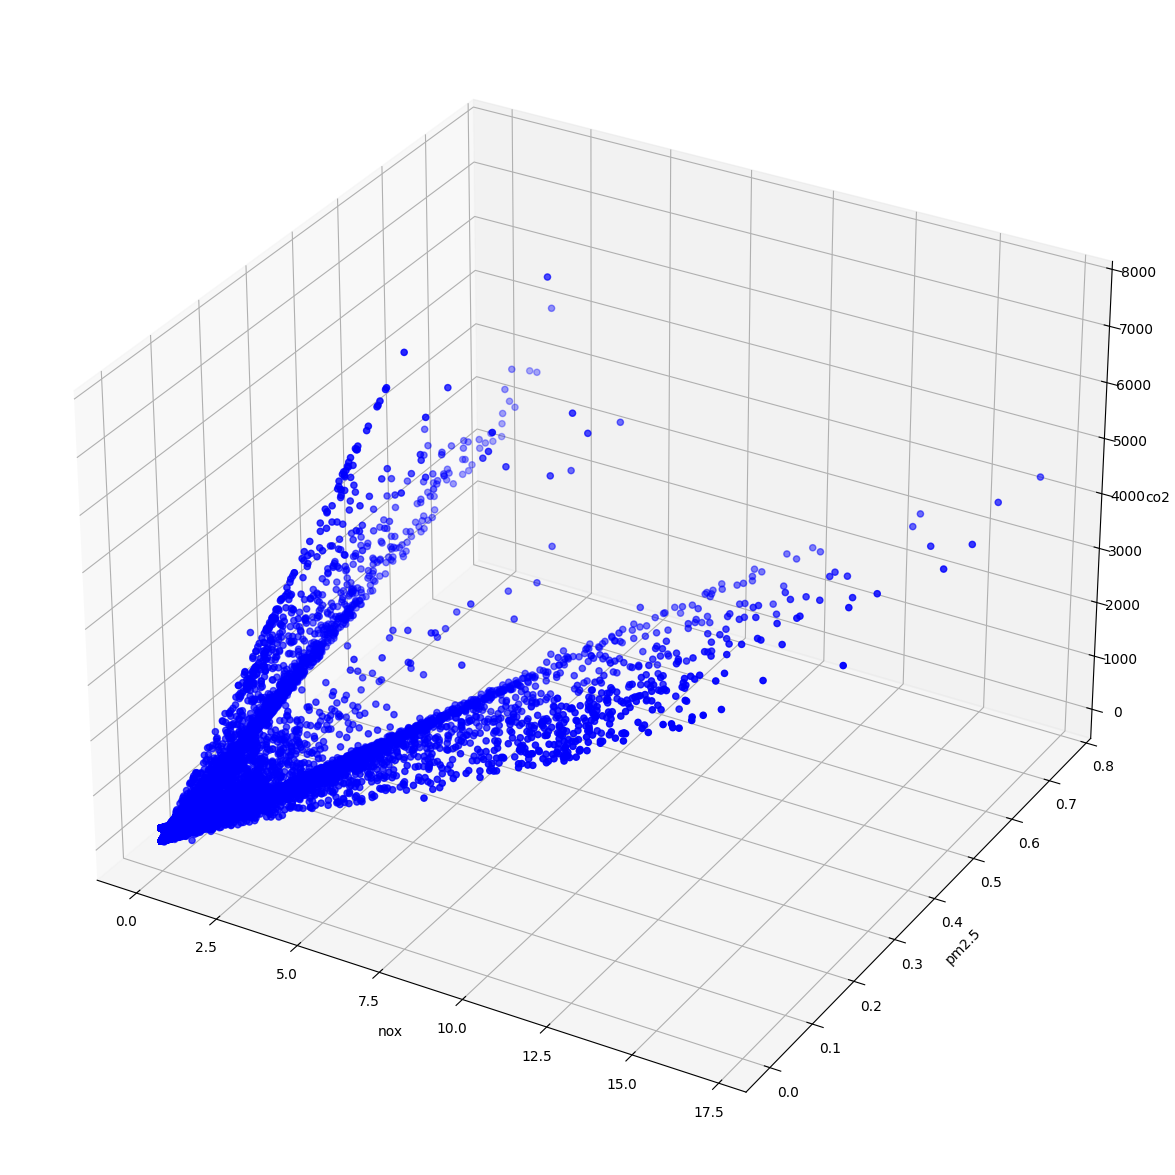

In [5]:
# Visualise dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset1['nox'], dataset1['pm2.5'], dataset1['co2'], c='b')
ax.set_xlabel("nox")
ax.set_ylabel("pm2.5")
ax.set_zlabel("co2")
plt.show()

In [6]:
# Save cleaned dataset to csv file
filename = "dataset_cleaned-v1.csv"
dataset1.to_csv(filename,index=False,encoding='utf-8')